<h1 style="text-align:center;color:blue;font-size:50px;font-family:ALGERIAN;border:solid">Projet de Machine Learning</h1>

<h1 style="text-align:center;color:blue;font-size:50px;font-family:times">Ecole Nationale de la Statistique et de l'Analyse Economique Pierre NDIAYE (ENSAE)</h1><br>

<div style="display:flex;text-align:justify">
    
    
<ul style="text-align:justify;font-family:times;font-size:15px;list-style-type:circle; width:60%"> 
<span style="font-weight:bold">Réalisé par : </span> 
    <ul style="text-align:justify;font-family:times;font-size:15px;list-style-type:circle"> 
        <li>Komla Alex LABOU</li>                                      
        <li>Dieynaba KA</li>
        <li>S. D. E. Laurine ADOGOUN</li>                                      
        <li>Moussa DIAKITE</li>
    </ul>
    <span style="font-style: italic;font-size:13px">Élèves Ingénieurs Statisticiens Economistes</span>
</ul>
 
<ul style="text-align:justify;font-family:times;font-size:15px;list-style-type:none;width:39%"> 
 <li style="font-weight:bold">Sous la supervision de :</li> 
 <li>Mme. Mously DIAW</li>                                     
   
</ul>
    
</div>   

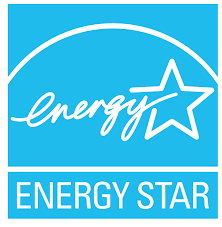

<h2 style="text-align:justify;color:blue;font-size:30px;font-family:ALGERIAN">I. PRELIMINAIRE</h2>

<h3 style="text-align:justify;color:black;font-size:26px;font-family:Georgia"> A. Définition de l'environnement de travail</h3>

In [121]:
from pathlib import Path

# définir le répertoire du projet contenant le dossier data/ et notebooks/
HOME = Path.cwd().parent
print(f"Home directory: {HOME}")

# définir le répertoire des données
DATA = Path(HOME, "data")
print(f"Data directory: {DATA}")

Home directory: C:\Users\DELL\Downloads\projet_ml
Data directory: C:\Users\DELL\Downloads\projet_ml\data


<h3 style="text-align:justify;color:black;font-size:26px;font-family:Georgia">B. Importation des packages</h3>

In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from sklearn.impute import KNNImputer
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV

In [122]:
data = pd.read_csv(Path(DATA, "2016_Building_Energy_final.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1521 non-null   object 
 1   CouncilDistrictCode              1521 non-null   int64  
 2   Neighborhood                     1521 non-null   object 
 3   YearBuilt                        1521 non-null   int64  
 4   NumberofBuildings                1521 non-null   float64
 5   NumberofFloors                   1521 non-null   int64  
 6   PropertyGFAParking               1521 non-null   int64  
 7   PropertyGFABuilding(s)           1521 non-null   int64  
 8   LargestPropertyUseTypeGFA        1521 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  1521 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   1521 non-null   float64
 11  ENERGYSTARScore                  1008 non-null   float64
 12  SiteEnergyUse(kBtu) 

In [123]:
# Sélectionnez les colonnes catégorielles
df_cat = data.select_dtypes(include=['object'])

# Sélectionnez les colonnes numériques
df_num = data.select_dtypes(exclude=['object'])

# Concaténez les DataFrames dans le bon ordre
data = pd.concat([df_cat, df_num], axis=1)
data = data.iloc[:, data.columns != "ENERGYSTARScore"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521 entries, 0 to 1520
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1521 non-null   object 
 1   Neighborhood                     1521 non-null   object 
 2   PrimaryProperty                  1521 non-null   object 
 3   SecondLargest                    1521 non-null   object 
 4   ThirdLargest                     1521 non-null   object 
 5   CouncilDistrictCode              1521 non-null   int64  
 6   YearBuilt                        1521 non-null   int64  
 7   NumberofBuildings                1521 non-null   float64
 8   NumberofFloors                   1521 non-null   int64  
 9   PropertyGFAParking               1521 non-null   int64  
 10  PropertyGFABuilding(s)           1521 non-null   int64  
 11  LargestPropertyUseTypeGFA        1521 non-null   float64
 12  SecondLargestPropert

In [124]:
X_index = data.columns != "SiteEnergyUse(kBtu)"  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"
y_index = data.columns == "SiteEnergyUse(kBtu)"  # Récupérer la colonne "SiteEnergyUse(kBtu)"

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X = data.iloc[:, X_index]
y = np.log1p(data.iloc[:, y_index])

<h2 style="text-align:justify;color:blue;font-size:30px;font-family:ALGERIAN">II. MODELISATION</h2>

<p style="text-align:justify;font-family:times;font-size:15px">
  Nous allons tester plusieurs modèles pour ensuite retenir le modèle qui semble être le meilleur et qui est susceptible de nous donner les meilleurs prédiction par la suite. Aussi, nous veillerons à optimiser les modèles qui feront du sur ou du sous-apprentissage en utilisant pour chaque modèle les paramètres adéquats.. </p>
  <p style="text-align:justify;font-family:times;font-size:15px">
Pour la modelisation, nous separons la variable target dans la variable y et nos variables explicatives dans la variable X. Ensuite, nous partagerons notre X et y en 
<span style="font-weight:bold">X_train</span>, <span style="font-weight:bold">y_train</span>,  <span style="font-weight:bold">X_test</span>, <span style="font-weight:bold">y_test</span>. Nous entrainerons notre modèle sur les X_train et les y_train puis nous les testerons sur X_test et y_test.</p>

<p style="text-align:justify;font-family:times;font-size:15px">
 De plus notre travail consistant à prédire la consommation d'énergie nous sommes en présence d'un problème de regression.Nous allons alors tester des algorithmes de regression partant des plus simples comme <span style="font-weight:bold">LinearRegression, ElasticNet, RidgeRegression</span> du fait de leur facilité d'implémentation. En parallèle nous exécuterons d'autre modèle non linéaire telle que le KNN qui est facile à omplémenter à comprendre eyt s'ajuste facilement pour de nouvelles données. Il a le mérite de n'avoir que deux hyperparamètres, donc facile de jouer sur ces derniers pour optimiser les performances du modèle. </p>

In [125]:
num_columns =  ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
                'YearBuilt',
                'NumberofBuildings',
                'NumberofFloors',
                'NumberOfPropertyUseTypes',
                'NombreAnnees'
                           
]
obj_columns = list(data.select_dtypes(include=['object', 'bool']).columns)
obj_columns,num_columns

(['BuildingType',
  'Neighborhood',
  'PrimaryProperty',
  'SecondLargest',
  'ThirdLargest'],
 ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'NumberOfPropertyUseTypes',
  'NombreAnnees'])

In [7]:
#pip install category_encoders

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from numpy import log

# Définition des étapes de transformation pour les variables qualitatives et numériques
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(func=np.log1p))
])

# Création du préprocesseur en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns),
        ('num', numeric_transformer, num_columns)
    ],remainder='passthrough')

In [9]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [127]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

<p style="text-align:justify;font-family:times;font-size:15px">Pour faciliter l'analyse de nos différents modèles, nous avons opté pour la Création de la fonction get_all_performances qui prend en argument un modèle, qui l'applique sur notre X et y train, puis predit les <span style="color:red">y_pred</span> en fonction des <span style="color:red">X_pred</span> puis nous donne le tableau recapitulatif des metriques sur l'échantillon train et l'echantillon test. Par ailleurs pour chaque modéle nous nutiliserons la méthode <span style="color:red"></span>GridSearchCV</span> pour determiner les meilleurs hyperparamètres.</p>

In [128]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)
METRICS = [metrics.r2_score,
           metrics.mean_squared_error,
           metrics.mean_absolute_percentage_error,
           metrics.max_error, metrics.mean_absolute_error,
          ]

In [132]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train).reshape(len(X_train),1) - y_train) ** 2)
    
    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test).reshape(len(X_test),1) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

<h3 style="text-align:justify;color:black;font-size:26px;font-family:Georgia"> A. Modélisation sans EnergyStarSCORE</h3>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">1. LinearRegression</h4>

In [130]:
reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.LinearRegression()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
reg_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees'])])),
                ('regressor', LinearRegression())])

In [133]:
lr_results = train_model(model=reg_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

Model error: SiteEnergyUse(kBtu)    0.2012
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


<p style="text-align:justify;font-family:times;font-size:15px">Vérifions les métriques d'évaluation de notre modèle.</p>

In [134]:
lr = lr_results["estimator"]
get_all_performances(value_train=(y_train, lr.predict(X_train)),
                     values_test=(y_test, lr.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.897818,0.876200
1,mean_squared_error,0.157691,0.201202
2,mean_absolute_percentage_error,0.020505,0.022257
3,max_error,2.483572,3.208325
4,mean_absolute_error,0.297023,0.319447


<p style="text-align:justify;font-family:times;font-size:15px">De façon générale, notre modèle apprend bien et généralise bien. Le r_2_score sur le train et le test sont assez intéressant. </p>

<h5 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">a. Optimisation des hyperparamètres</h5>

In [135]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.LinearRegression()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
reg_pipe

# Train and evaluate ridge regression
lr_results = train_model(model=reg_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

lr_pipe = lr_results["estimator"]
param_grid = {
    "regressor__fit_intercept": [True, False],
}

grid_search = GridSearchCV(reg_pipe, param_grid, cv=10, scoring="r2", return_train_score=True)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Model error: SiteEnergyUse(kBtu)    0.2012
dtype: float64
Best params: {'regressor__fit_intercept': True}


<p style="text-align:justify;font-family:times;font-size:15px">Le meilleur modèle de regression linéaire est celui avec ordonnée à l'origine. </p>

In [136]:
grid_cv_results = grid_search.cv_results_
lr_best_model = grid_search.best_estimator_

In [145]:
grid_search.best_estimator_[-1].coef_.shape

(1, 63)

<h5 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">b. Importances des features</h5>

In [146]:
encoded_categorical_column_names = preprocessor.named_transformers_['cat']\
    .named_steps['onehot'].get_feature_names_out(input_features=obj_columns)

# Récupérer les noms des colonnes pour les variables numériques
numeric_column_names = num_columns

# Concaténer les noms des colonnes catégorielles encodées et les noms des colonnes numériques
all_column_names = ['Intercept'] + list(encoded_categorical_column_names) + list(numeric_column_names)

In [147]:
encoded_column_names = reg_pipe.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['onehot'].get_feature_names_out(input_features=obj_columns)
df_feature_importance = pd.DataFrame(grid_search.best_estimator_[-1].coef_.reshape(63,1), columns=["coef"], index=all_column_names)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance

Shape: (63, 1)


,coef
Intercept,-0.000349
BuildingType_CAMPUS,-0.163846
BuildingType_NONRESIDENTIAL,-0.157878
BuildingType_NONRESIDENTIAL COS,0.558135
BuildingType_NONRESIDENTIAL WA,-0.236060
...,...
YearBuilt,0.016294
NumberofBuildings,0.077441
NumberofFloors,-0.122711
NumberOfPropertyUseTypes,0.075400


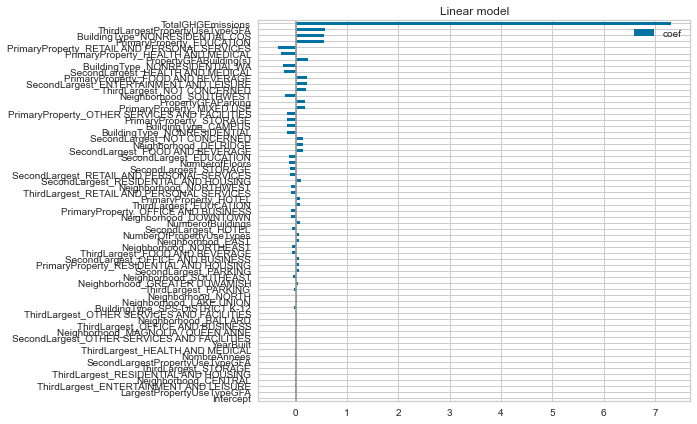

In [148]:
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

<p style="text-align:justify;font-family:times;font-size:15px">On voit comment la variable emission d'energie influence très positivement la consommation d'énergie. Cecoi est tout à fait normal du fait que l'émession du gaz à effet de serre se déduit de la consommation d'énergie</p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">2. ElasticNet</h4>

In [149]:
en_pipe = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
en_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees'])])),
                ('regressor', ElasticNet())])

In [150]:
en_results = train_model(model=en_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

Model error: SiteEnergyUse(kBtu)    0.61724
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


<h5 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">a. Optimisation des hyperparamètres</h5>

In [151]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
en_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
en_pipe
# Train and evaluate ridge regression
en_results = train_model(model=en_pipe,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

eln_pipe = en_results["estimator"]

Model error: SiteEnergyUse(kBtu)    0.61724
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [152]:
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 2000, 3000],
    'regressor__tol': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(en_pipe, param_grid, cv=10, scoring="r2", return_train_score=True)
grid_search
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")
grid_cv_results = grid_search.cv_results_

eln_best_model = grid_search.best_estimator_

Best params: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}


<h5 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">b. Importances des features</h5>

Shape: (63, 1)


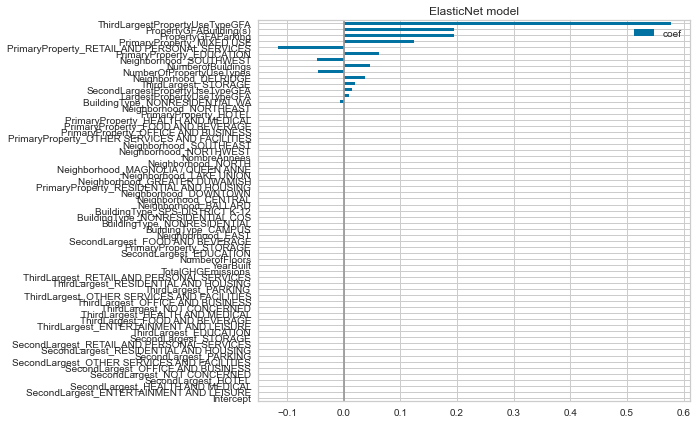

In [154]:
df_feature_importance = pd.DataFrame(grid_search.best_estimator_[-1].coef_.reshape(63,1), columns=["coef"], index=all_column_names)
print(f"Shape: {df_feature_importance.shape}")
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("ElasticNet model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

<p style="text-align:justify;font-family:times;font-size:15px">On voit clairement que les superificies du parking, building, le nombre de batiments ainsi que quelques propriétés primaire permettent de déterminer la consommation d'énergie. Nous allons donc essayer d'appliquer un modèle que sur ces variables là. </p>

In [163]:
X_index_eln = ['ThirdLargest','ThirdLargestPropertyUseTypeGFA','PrimaryProperty'
               ,'NumberOfPropertyUseTypes','PropertyGFABuilding(s)',
               'PropertyGFAParking','Neighborhood','NumberofBuildings']  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"


# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X_train_eln = X_train.loc[:, X_index_eln]

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X_test_eln = X_test.loc[:, X_index_eln]

num_columns_2 = ['ThirdLargestPropertyUseTypeGFA',
               'NumberOfPropertyUseTypes','PropertyGFABuilding(s)',
               'PropertyGFAParking','NumberofBuildings']
obj_columns_2 = ['PrimaryProperty','ThirdLargest','Neighborhood']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('log1p', FunctionTransformer(func=np.log1p))
])

# Création du préprocesseur en utilisant ColumnTransformer
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns_2),
        ('num', numeric_transformer, num_columns_2)
    ],remainder='passthrough')

In [164]:
en_pipe_2 = Pipeline(steps=[('preprocessor_2', preprocessor_2),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
en_pipe_2
en_results_2 = train_model(model=en_pipe_2,
                       x_train=X_train_eln, y_train=y_train,
                       x_test=X_test_eln, y_test=y_test)
en_estimator_2 = en_results_2["estimator"]

get_all_performances(value_train=(y_train, en_estimator_2.predict(X_train_eln)),
                     values_test=(y_test, en_estimator_2.predict(X_test_eln)),
                     metrics=METRICS
                    )

Model error: SiteEnergyUse(kBtu)    1.19464
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,0.266859,0.264938
1,mean_squared_error,1.131407,1.194642
2,mean_absolute_percentage_error,0.055653,0.058418
3,max_error,4.580630,4.806922
4,mean_absolute_error,0.816036,0.845886


In [165]:
param_grid = {
    'regressor__alpha': [0.1, 0.5, 1.0],
    'regressor__l1_ratio': [0.1, 0.5, 0.9],
    'regressor__fit_intercept': [True, False],
    'regressor__max_iter': [1000, 2000, 3000],
    'regressor__tol': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(en_pipe_2, param_grid, cv=10, scoring="r2", return_train_score=True)
grid_search
grid_search.fit(X_train_eln, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 1000, 'regressor__tol': 0.01}


In [166]:

eln_best_model = grid_search.best_estimator_
eln_best_model.fit(X_train_eln, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, eln_best_model.predict(X_train_eln)),
                     values_test=(y_test, eln_best_model.predict(X_test_eln)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.632984,0.594060
1,mean_squared_error,0.566391,0.659745
2,mean_absolute_percentage_error,0.038431,0.041188
3,max_error,4.710104,4.453478
4,mean_absolute_error,0.556026,0.588455


<p style="text-align:justify;font-family:times;font-size:15px">  La  part de variance exppliquée par ce modèle n'est pas élevée et les erreurs bien qu'étant pas différent sur le test et le train sont quand même élevées. </p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">3. DecisionTree</h4>

In [168]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = Pipeline(steps=[('preprocessor', preprocessor),
                           ("regressor", DecisionTreeRegressor()),
                          ]
                   )
dt_reg
dt_results = train_model(model=dt_reg,
                       x_train=X_train, y_train=y_train,
                       x_test=X_test, y_test=y_test)

dt_estimator = dt_results["estimator"]
dt_estimator
# get performances in train & test
get_all_performances(value_train=(y_train, dt_estimator.predict(X_train)),
                     values_test=(y_test, dt_estimator.predict(X_test)),
                     metrics=METRICS
                    )

Model error: SiteEnergyUse(kBtu)    0.37106
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,1.0,0.771690
1,mean_squared_error,0.0,0.371055
2,mean_absolute_percentage_error,0.0,0.028031
3,max_error,0.0,4.617085
4,mean_absolute_error,0.0,0.412220


<p style="text-align:justify;font-family:times;font-size:15px"> On voit alors que notre modèle surapprend. Réglons cela en optimisant les hyperparamètres.  </p>

<p style="text-align:justify;color:blue;font-size:15px;font-family:Roboto">Optimisation des hyperparamètres</p>

In [170]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Créer un pipeline avec le modèle Decision Tree
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
    ("regressor", DecisionTreeRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__max_depth': [None, 5, 10, 15],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=dt_pipe, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\DELL\anacon

Meilleurs paramètres: {'regressor__max_depth': 10, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


<p style="text-align:justify;font-family:times;font-size:15px">Appliquons le meilleur modèle alors à nos données. </p>

In [171]:
dt_best_model = grid_search.best_estimator_
dt_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, dt_best_model.predict(X_train)),
                     values_test=(y_test, dt_best_model.predict(X_test)),
                     metrics=METRICS)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


,metric,train,test
0,r2_score,0.944956,0.830987
1,mean_squared_error,0.084946,0.274684
2,mean_absolute_percentage_error,0.014095,0.023558
3,max_error,1.256584,5.053674
4,mean_absolute_error,0.205668,0.346220


<p style="text-align:justify;font-family:times;font-size:15px">  Bien que les erreurs aient diminué elles sont moindre sur le jeu d'entrainement que sur le jeu de test. Le risque de surapprentissage persiste. </p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">4. RandomForest</h4>

In [172]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", RandomForestRegressor())
])

# Entraîner le modèle Random Forest
rf_results = train_model(model=rf_reg,
                         x_train=X_train, y_train=y_train,
                         x_test=X_test, y_test=y_test)

# Obtenir l'estimateur du modèle Random Forest
rf_estimator = rf_results["estimator"]

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rf_estimator.predict(X_train)),
                     values_test=(y_test, rf_estimator.predict(X_test)),
                     metrics=METRICS)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Model error: SiteEnergyUse(kBtu)    0.2194
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,0.984590,0.865005
1,mean_squared_error,0.023782,0.219398
2,mean_absolute_percentage_error,0.007226,0.020408
3,max_error,0.697762,5.238787
4,mean_absolute_error,0.106082,0.299389


<p style="text-align:justify;color:blue;font-size:15px;font-family:Roboto">Optimisation des hyperparamètres</p>

In [173]:
rf_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", RandomForestRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [5, 10],
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

Meilleurs paramètres: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


In [174]:
# Entraîner le modèle Random Forest avec les meilleurs paramètres trouvés
rf_best_model = grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rf_best_model.predict(X_train)),
                     values_test=(y_test, rf_best_model.predict(X_test)),
                     metrics=METRICS)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,metric,train,test
0,r2_score,0.969054,0.866281
1,mean_squared_error,0.047757,0.217323
2,mean_absolute_percentage_error,0.010543,0.020435
3,max_error,0.884892,5.096181
4,mean_absolute_error,0.154273,0.299542


<p style="text-align:justify;font-family:times;font-size:15px">  Bien que les erreurs aient diminué, l'écart entre les erreurs sur le jeu d'apprentissage et le jeu de test est assez grand. Le modèle ne performe que sur le jeu d'entrainement. Essatons de voir si on ne peut éliminer certaines variables pour améliorer la performance de notre modèle. Pour cela nous ferons appel au PPScore</p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">5. XGBoost</h4>

In [ ]:
pip install xgboost

In [176]:
import xgboost
from xgboost import XGBRegressor
xgb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", XGBRegressor())
])

# Entraîner le modèle XGBoost
xgb_results = train_model(model=xgb_reg,
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

# Obtenir l'estimateur du modèle XGBoost
xgb_estimator = xgb_results["estimator"]

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, xgb_estimator.predict(X_train)),
                     values_test=(y_test, xgb_estimator.predict(X_test)),
                     metrics=METRICS)

Model error: SiteEnergyUse(kBtu)    0.19595
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,0.998823,0.879431
1,mean_squared_error,0.001817,0.195952
2,mean_absolute_percentage_error,0.001964,0.022247
3,max_error,0.189428,2.259458
4,mean_absolute_error,0.028552,0.324385


<p style="text-align:justify;font-family:times;font-size:15px"> Le coefficient de détermination (r2_score) est proche de 1 pour l'ensemble d'entraînement, ce qui suggère que le modèle explique bien la variance des données d'entraînement. Cependant, il est légèrement inférieur pour l'ensemble de test, indiquant une légère baisse de performance lorsqu'on évalue le modèle sur des données qu'il n'a pas vues pendant l'entraînement. Il y a une possibilité de surajustement, mais dans l'ensemble, le modèle semble bien généraliser. </p>

<p style="text-align:justify;font-family:times;font-size:15px"> L'erreur quadratique moyenne (mean_squared_error) est très faible pour l'ensemble d'entraînement, indiquant de bonnes performances de prédiction sur ces données. Cependant, elle est plus élevée pour l'ensemble de test, ce qui signifie que les prédictions du modèle sont moins précises sur de nouvelles données.</p>

<p style="text-align:justify;color:blue;font-size:15px;font-family:Roboto">Optimisation des hyperparamètres</p>

In [177]:
xgb_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", XGBRegressor())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__min_child_weight': [1, 3, 5]
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

Meilleurs paramètres: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 100}


In [178]:

# Entraîner le modèle XGBoost avec les meilleurs paramètres trouvés
xgb_best_model = grid_search.best_estimator_
xgb_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, xgb_best_model.predict(X_train)),
                     values_test=(y_test, xgb_best_model.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.968906,0.900654
1,mean_squared_error,0.047985,0.161460
2,mean_absolute_percentage_error,0.010421,0.019906
3,max_error,0.964597,2.130011
4,mean_absolute_error,0.151647,0.289658


<p style="text-align:justify;font-family:times;font-size:15px">  Le coefficient de détermination (r2_score) est élevé pour les deux ensembles, ce qui indique que le modèle capture bien la variance des données. Il y a une légère baisse de performance par rapport à l'ensemble d'entraînement, mais le modèle semble généraliser raisonnablement bien sur l'ensemble de test. </p>
<p style="text-align:justify;font-family:times;font-size:15px">  L'erreur quadratique moyenne (mean_squared_error) est plus faible pour l'ensemble d'entraînement que pour l'ensemble de test, ce qui indique que le modèle a une meilleure précision sur les données d'entraînement. Cependant, les valeurs sont toutes deux acceptables et indiquent une bonne capacité du modèle à prédire les valeurs cibles. </p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">6. Support Vector Regressor</h4>

<p style="text-align:justify;font-family:times;font-size:15px">Le Support Vector Regressor (SVR) est un algorithme d'apprentissage supervisé utilisé pour la régression. Contrairement aux méthodes traditionnelles, SVR vise à minimiser le risque structurel plutôt que l'erreur de prédiction, en optimisant une marge maximale entre les points de données et une droite de régression. Il utilise des fonctions de noyau pour gérer les relations non linéaires entre les variables et est robuste aux données bruitées grâce à la gestion des marges. SVR est efficace même dans les espaces de grande dimension, ce qui en fait un choix adapté pour les ensembles de données complexes ou comportant un grand nombre de variables explicatives.</p>

In [179]:
from sklearn.svm import SVR
svr_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", SVR())
])

# Entraîner le modèle SVR
svr_results = train_model(model=svr_reg,
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

# Obtenir l'estimateur du modèle SVR
svr_estimator = svr_results["estimator"]

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, svr_estimator.predict(X_train)),
                     values_test=(y_test, svr_estimator.predict(X_test)),
                     metrics=METRICS)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Model error: SiteEnergyUse(kBtu)    0.23301
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,0.885080,0.856627
1,mean_squared_error,0.177349,0.233014
2,mean_absolute_percentage_error,0.021370,0.023839
3,max_error,2.748955,3.043635
4,mean_absolute_error,0.309758,0.342690


<p style="text-align:justify;font-family:times;font-size:15px">  Le modèle de SVR a un coefficient de détermination aussi bien sur le test que sur le train proche de 1. Ce qui veut dire qu'il explique bien la variance. En terme d'erreur, les erreurs sont généralement faible et un peu plus élevé sur le jeu d'entrainement. Cependant la marge n'étant pas assez, le modèle généralisera bien. </p>

<p style="text-align:justify;color:blue;font-size:15px;font-family:Roboto">Optimisation des hyperparamètres</p>

In [180]:
svr_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", SVR())
])

# Définir la grille des paramètres à rechercher
param_grid = {
    'regressor__kernel': ['linear', 'rbf'],
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': ['scale', 'auto']
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=svr_reg, param_grid=param_grid, cv=5, scoring='r2')

# Exécuter la recherche sur la grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Meilleurs paramètres: {'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}


In [181]:

# Entraîner le modèle SVR avec les meilleurs paramètres trouvés
svr_best_model = grid_search.best_estimator_
svr_best_model.fit(X_train, y_train)

# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, svr_best_model.predict(X_train)),
                     values_test=(y_test, svr_best_model.predict(X_test)),
                     metrics=METRICS)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,metric,train,test
0,r2_score,0.903230,0.870426
1,mean_squared_error,0.149339,0.210587
2,mean_absolute_percentage_error,0.018663,0.022410
3,max_error,2.794815,3.131595
4,mean_absolute_error,0.269487,0.321970


<p style="text-align:justify;font-family:times;font-size:15px">  Les erreurs sont minimisés et la part de variance expliquée encore plus grande autant sur les jeux d'entrainement que de test. </p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">7. Comparaison des modèles</h4>

<p style="text-align:justify;font-family:times;font-size:15px"> Passons en revue les différents meilleurs modèles obtenues avec leur score </p>

In [183]:
models = [svr_best_model, xgb_best_model, rf_best_model, lr_best_model, eln_best_model, dt_best_model]
model_names = ['SVR', 'XGBoost', 'Random Forest', 'Linear Regression', 'ElasticNet', 'Decision Tree']

for model, model_name in zip(models, model_names):
    print("Model:", model_name)
    print(get_all_performances(value_train=(y_train, model.predict(X_train)),
                                values_test=(y_test, model.predict(X_test)),
                                metrics=METRICS))
    print("\n")

Model: SVR
                           metric     train      test
0                        r2_score  0.903230  0.870426
1              mean_squared_error  0.149339  0.210587
2  mean_absolute_percentage_error  0.018663  0.022410
3                       max_error  2.794815  3.131595
4             mean_absolute_error  0.269487  0.321970


Model: XGBoost
                           metric     train      test
0                        r2_score  0.968906  0.900654
1              mean_squared_error  0.047985  0.161460
2  mean_absolute_percentage_error  0.010421  0.019906
3                       max_error  0.964597  2.130011
4             mean_absolute_error  0.151647  0.289658


Model: Random Forest
                           metric     train      test
0                        r2_score  0.969054  0.866281
1              mean_squared_error  0.047757  0.217323
2  mean_absolute_percentage_error  0.010543  0.020435
3                       max_error  0.884892  5.096181
4             mean_absolute_err

<p style="text-align:justify;font-family:times;font-size:15px"> La comparaison de ces modèles nous permet de conclure que le xgboost est le meilleur modèle en terme de variance expliquée et de pourcentage d'erreur tant sur le jeu de données test que celui d'entrainement</p>

<h3 style="text-align:justify;color:black;font-size:26px;font-family:Georgia"> B. Modélisation avec EnergyStarSCORE</h3>

In [203]:
data_2 = pd.read_csv(Path(DATA, "2016_Building_Energy_final.csv"))

In [259]:
df_cat = data_2.select_dtypes(include=['object'])

# Sélectionnez les colonnes numériques
df_num = data_2.select_dtypes(exclude=['object'])

# Concaténez les DataFrames dans le bon ordre
data_2 = pd.concat([df_cat, df_num], axis=1)
X_index = data_2.columns != "SiteEnergyUse(kBtu)"  # Récupérer les colonnes différentes de "SiteEnergyUse(kBtu)"
y_index = data_2.columns == "SiteEnergyUse(kBtu)"  # Récupérer la colonne "SiteEnergyUse(kBtu)"

# Séparer les caractéristiques (X) et la cible (y) en utilisant iloc
X = data_2.iloc[:, X_index]
y = np.log1p(data_2.iloc[:, y_index])

In [260]:
num_columns =  ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
                'YearBuilt',
                'NumberofBuildings',
                'NumberofFloors',
                'NumberOfPropertyUseTypes',
                'NombreAnnees'
                           
]
obj_columns = list(data_2.select_dtypes(include=['object', 'bool']).columns)
obj_columns,num_columns

(['BuildingType',
  'Neighborhood',
  'PrimaryProperty',
  'SecondLargest',
  'ThirdLargest'],
 ['PropertyGFAParking',
  'PropertyGFABuilding(s)',
  'LargestPropertyUseTypeGFA',
  'SecondLargestPropertyUseTypeGFA',
  'ThirdLargestPropertyUseTypeGFA',
  'TotalGHGEmissions',
  'YearBuilt',
  'NumberofBuildings',
  'NumberofFloors',
  'NumberOfPropertyUseTypes',
  'NombreAnnees'])

In [270]:
X_train.columns

Index(['BuildingType', 'Neighborhood', 'PrimaryProperty', 'SecondLargest',
       'ThirdLargest', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'TotalGHGEmissions', 'NumberOfPropertyUseTypes', 'NombreAnnees'],
      dtype='object')

In [262]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [271]:
from sklearn.impute import KNNImputer

# Ajout d'un imputeur KNN pour la variable EnergyStarScore
imputer_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))  # Vous pouvez ajuster le nombre de voisins selon votre besoin
])

# Ajout de l'imputation KNN dans le préprocesseur existant
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, obj_columns),
        ('num', numeric_transformer, num_columns),
        ('impute', imputer_transformer, ['ENERGYSTARScore'])  # Traitement spécifique pour EnergyStarScore
    ]
)

# Création du pipeline final avec le préprocesseur
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BuildingType',
                                                   'Neighborhood',
                                                   'PrimaryProperty',
                                                   'SecondLargest',
                                                   'ThirdLargest']),
                                                 ('num',
                                                  Pipeline(steps=[('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'TotalGHGEmissions',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'NumberOfPropertyUseTypes',
                                                   'NombreAnnees']),
                                                 ('impute',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['ENERGYSTARScore'])]))])

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">1. LinearRegression</h4>

In [282]:
rfe_pipe = Pipeline([
    ("preprocess", final_pipeline),
    ("feature_selection", RFE(estimator=linear_model.LinearRegression(), n_features_to_select=27)),
    ("regressor", linear_model.LinearRegression())
])
rfe_results = train_model(model=rfe_pipe, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_pipe = rfe_results["estimator"]
# Afficher les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rfe_pipe.predict(X_train)),
                     values_test=(y_test, rfe_pipe.predict(X_test)),
                     metrics=METRICS)

Model error: SiteEnergyUse(kBtu)    0.20335
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,0.893773,0.874880
1,mean_squared_error,0.163933,0.203349
2,mean_absolute_percentage_error,0.020939,0.022297
3,max_error,2.548878,3.170357
4,mean_absolute_error,0.303263,0.320138


<p style="text-align:justify;font-family:times;font-size:15px"> Ci dessus. Nous avons entrainé notre modèle en tenant compte de la présence de ENERGYSTARScore mais également en ne sélectionnant que les 10 variables qui apportent assez dans la détermination de notre variable cible. Et les résultats sont assez convaincants avec une part de variance expliquée assez élevée. Egalement les erreurs effectuées aussi bien sur le test que sur le score sont acceptables.  Cependant plus on réduit les variables moins est la performance du modèle. En effet le modèle sans élimination des variables nous avait donné ceci</p>

In [279]:
lr = lr_results["estimator"]
get_all_performances(value_train=(y_train, lr.predict(X_train)),
                     values_test=(y_test, lr.predict(X_test)),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.911029,0.892809
1,mean_squared_error,0.137302,0.174210
2,mean_absolute_percentage_error,0.018605,0.020489
3,max_error,2.590801,2.760107
4,mean_absolute_error,0.269881,0.294008


<p style="text-align:justify;font-family:times;font-size:15px"> En intégrant l'EnergyStarScore, la performance de ce modèle s'améliore nettement à mesure qu'on utilise toutes les variables. </p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">2. XGBoost</h4>

In [298]:
from xgboost import XGBRegressor  # Importez XGBRegressor


rfe_pipe_xgb = Pipeline([
    ("preprocess", final_pipeline),
    ("feature_selection", RFE(estimator=XGBRegressor(), n_features_to_select=10)),
    ("regressor", XGBRegressor())
])


rfe_results_xgb = train_model(model=rfe_pipe_xgb, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_pipe_xgb = rfe_results_xgb["estimator"]

# Affichez les performances sur les ensembles d'entraînement et de test
get_all_performances(value_train=(y_train, rfe_pipe_xgb.predict(X_train)),
                     values_test=(y_test, rfe_pipe_xgb.predict(X_test)),
                     metrics=METRICS)


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Model error: SiteEnergyUse(kBtu)    0.15542
dtype: float64


,metric,train,test
0,r2_score,0.997824,0.904372
1,mean_squared_error,0.003359,0.155418
2,mean_absolute_percentage_error,0.002533,0.019744
3,max_error,0.344745,1.632287
4,mean_absolute_error,0.036976,0.287473


<p style="text-align:justify;font-family:times;font-size:15px"> Ici, l'intégration de l'EnergyStarScore a augmenté la performance de notre modèle mais avec un risque de surraprentissage. Essayons d'éliminer cela avec une optimisation des hyperparamètres y compris le nombre de variables à sélectionner</p>

In [299]:
param_grid = {
    'feature_selection__n_features_to_select': [10,15,20],  # Nombre de caractéristiques à sélectionner
    'regressor__n_estimators': [100, 200, 300],  # Nombre d'estimateurs dans XGBoost
}

# Initialisez GridSearchCV avec votre pipeline et la grille de paramètres
grid_search = GridSearchCV(estimator=rfe_pipe_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Effectuez la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle trouvé
best_model_xbgrfe = grid_search.best_estimator_

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('cat',
                                                                   Pipeline(steps=[('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['BuildingType',
                                                                    'Neighborhood',
                                                                    'PrimaryProperty',
                                                                    'SecondLargest',
                                                                    'ThirdLargest']),
                                                                  ('num',
                                                                   Pipeline(steps=[('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                   ['PropertyGFAParking',
                                                                    '...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [301]:
get_all_performances(value_train=(y_train, best_model_xbgrfe.predict(X_train)),
                     values_test=(y_test, best_model_xbgrfe.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.999102,0.911194
1,mean_squared_error,0.001386,0.144331
2,mean_absolute_percentage_error,0.001650,0.018765
3,max_error,0.242396,1.687950
4,mean_absolute_error,0.024112,0.273658


<p style="text-align:justify;font-family:times;font-size:15px"> On voit alors que la part de variance a vraiment augmenté.  Les erreurs ont quant à elle diminué aussi.</p>

<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">3. Decision Tree</h4>

<p style="text-align:justify;font-family:times;font-size:15px"> Dans ce cas également, nous allons tester le modèle avec EnergyStar Score et sélectionner celui avec les 10 variables assurant une bonne performance du modèle.  </p>

In [302]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline


dt_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("regressor", DecisionTreeRegressor())
])

rfe_dt_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)),
    ("regressor", DecisionTreeRegressor())
])

rfe_results = train_model(model=rfe_dt_reg, x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test)
rfe_estimator = rfe_results["estimator"]

get_all_performances(value_train=(y_train, rfe_estimator.predict(X_train)),
                     values_test=(y_test, rfe_estimator.predict(X_test)),
                     metrics=METRICS)

Model error: SiteEnergyUse(kBtu)    0.33384
dtype: float64


C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\DELL\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,metric,train,test
0,r2_score,1.0,0.794590
1,mean_squared_error,0.0,0.333838
2,mean_absolute_percentage_error,0.0,0.026266
3,max_error,0.0,4.617085
4,mean_absolute_error,0.0,0.385853


In [303]:
param_grid = {
    'feature_selection__n_features_to_select': [10, 15, 20],  # Nombre de caractéristiques à sélectionner
    'regressor__max_depth': [None, 10, 20],  # Profondeur maximale de l'arbre de décision
    'regressor__min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud  # Nombre minimum d'échantillons requis pour être à un nœud feuille
}

# Initialisez GridSearchCV avec votre pipeline et la grille de paramètres
grid_search = GridSearchCV(estimator=rfe_dt_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Effectuez la recherche sur grille
grid_search.fit(X_train, y_train)

# Obtenez le meilleur modèle trouvé
best_model_rfe_dt_reg = grid_search.best_estimator_

In [304]:
get_all_performances(value_train=(y_train, best_model_rfe_dt_reg.predict(X_train)),
                     values_test=(y_test, best_model_rfe_dt_reg.predict(X_test)),
                     metrics=METRICS)

,metric,train,test
0,r2_score,0.958320,0.825237
1,mean_squared_error,0.064322,0.284030
2,mean_absolute_percentage_error,0.011923,0.024002
3,max_error,1.199341,5.053674
4,mean_absolute_error,0.174114,0.351646


<h4 style="text-align:justify;color:red;font-size:20px;font-family:Roboto">4. Choix du meilleur modèle. </h4>

In [305]:
models = [lr, best_model_rfe_dt_reg, best_model_xbgrfe]
model_names = ['Regression Linéaire','Meilleur Modèle Decision Tree avec RFE','Meilleur Modèle XGBoost avec RFE']

for model, model_name in zip(models, model_names):
    print("Model:", model_name)
    print(get_all_performances(value_train=(y_train, model.predict(X_train)),
                                values_test=(y_test, model.predict(X_test)),
                                metrics=METRICS))
    print("\n")

Model: Regression Linéaire
                           metric     train      test
0                        r2_score  0.911029  0.892809
1              mean_squared_error  0.137302  0.174210
2  mean_absolute_percentage_error  0.018605  0.020489
3                       max_error  2.590801  2.760107
4             mean_absolute_error  0.269881  0.294008


Model: Meilleur Modèle Decision Tree avec RFE
                           metric     train      test
0                        r2_score  0.958320  0.825237
1              mean_squared_error  0.064322  0.284030
2  mean_absolute_percentage_error  0.011923  0.024002
3                       max_error  1.199341  5.053674
4             mean_absolute_error  0.174114  0.351646


Model: Meilleur Modèle XGBoost avec RFE
                           metric     train      test
0                        r2_score  0.999102  0.911194
1              mean_squared_error  0.001386  0.144331
2  mean_absolute_percentage_error  0.001650  0.018765
3                  

<p style="text-align:justify;font-family:times;font-size:15px">Les trois modèles évalués présentent des performances variées. La Régression Linéaire montre une bonne capacité à expliquer la variance des données, avec des résultats cohérents sur les ensembles d'entraînement et de test, bien que légèrement inférieurs à ceux des modèles à base d'arbres. Le Meilleur Modèle Decision Tree avec RFE affiche de très bonnes performances sur l'ensemble d'entraînement, mais semble souffrir d'un certain sur-ajustement, ce qui se traduit par des performances relativement moins bonnes sur l'ensemble de test. En revanche, le Meilleur Modèle XGBoost avec RFE se distingue par des performances exceptionnelles sur les deux ensembles, avec une capacité de généralisation élevée et des erreurs de prédiction minimales. Ainsi, le modèle XGBoost semble être le choix le plus prometteur pour cette tâche de prédiction, offrant un équilibre optimal entre précision et généralisation. </p>

<h3 style="text-align:justify;color:black;font-size:26px;font-family:Georgia"> C. Meilleur Modèle en considérant les deux approches</h3>

In [296]:
models = [xgb_best_model, best_model_xbgrfe]
model_names = ['Meilleur Modèle avec SANS ENERGY','Meilleur Modèle avec ENERGY et RFE']

for model, model_name in zip(models, model_names):
    print("Model:", model_name)
    print(get_all_performances(value_train=(y_train, model.predict(X_train)),
                                values_test=(y_test, model.predict(X_test)),
                                metrics=METRICS))
    print("\n")

Model: Meilleur Modèle avec SANS ENERGY
                           metric     train      test
0                        r2_score  0.968906  0.900654
1              mean_squared_error  0.047985  0.161460
2  mean_absolute_percentage_error  0.010421  0.019906
3                       max_error  0.964597  2.130011
4             mean_absolute_error  0.151647  0.289658


Model: Meilleur Modèle avec ENERGY et RFE
                           metric     train      test
0                        r2_score  0.999102  0.911194
1              mean_squared_error  0.001386  0.144331
2  mean_absolute_percentage_error  0.001650  0.018765
3                       max_error  0.242396  1.687950
4             mean_absolute_error  0.024112  0.273658




<p style="text-align:justify;font-family:times;font-size:15px">Les deux modèles évalués, le Meilleur Modèle sans la variable ENERGY et le Meilleur Modèle avec ENERGY et RFE, présentent des performances impressionnantes, bien que légèrement différentes. Le Meilleur Modèle sans la variable ENERGY affiche des performances remarquables sur les ensembles d'entraînement et de test, avec un coefficient de détermination (R²) élevé de 0.969 sur l'ensemble d'entraînement et 0.901 sur l'ensemble de test. Les erreurs moyennes absolues et quadratiques sont également très faibles, ce qui indique une capacité élevée du modèle à prédire les valeurs cibles. D'autre part, le Meilleur Modèle avec ENERGY et RFE présente des performances légèrement supérieures avec un R² de 0.999 sur l'ensemble d'entraînement et de 0.911 sur l'ensemble de test. Les erreurs moyennes absolues et quadratiques sont également très faibles, ce qui témoigne de la puissance prédictive du modèle. En conclusion, bien que les deux modèles soient performants, le Meilleur Modèle avec ENERGY et RFE semble légèrement plus précis, offrant des performances supérieures sur les ensembles de test. Cependant, il est important de prendre en compte d'autres facteurs tels que la complexité du modèle et la facilité d'interprétation lors du choix du modèle final.</p>